In [26]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
style.set_style()

# load results from a directory

In [189]:
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/mnist_5_5'
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/mnist_5_5_flip'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/cifar10_5_5_flip'
fnames = sorted([fname for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 21/21 [00:00<00:00, 75.14it/s]


**add cols**

In [190]:
# results.keys()

In [191]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
print(results.shape)

(17, 84)


In [192]:
idxs = results.index
results['mid_train_acc'] = np.array([results.accs_train[i][29] for i in idxs]) 
results['final_train_acc'] = np.array([results.accs_train[i][-1] for i in idxs]) 
results['final_test_acc'] = np.array([results.accs_test[i][-1] for i in idxs]) 
results['final_train_margin'] = np.array([results.mean_margin_train[i][-1] for i in idxs]) 
results['final_train_margin_unn'] = np.array([results.mean_margin_train_unn[i][-1] for i in idxs]) 
results['final_test_margin'] = np.array([results.mean_margin_test[i][-1] for i in idxs]) 
results['final_test_margin_unn'] = np.array([results.mean_margin_test_unn[i][-1] for i in idxs]) 

In [193]:
sweep_params = ['num_layers', 'optimizer', 'lr']# wanna group by everything but seed
r = results
r_mu = r.groupby(sweep_params).mean()
# r_std = r.groupby(sweep_params).std()

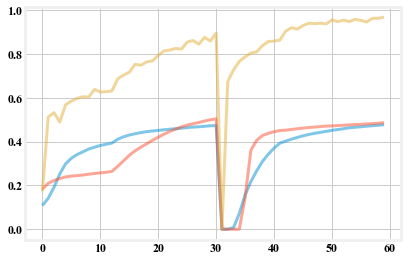

In [194]:
for i in results.index[3:6]:
    plt.plot(results['accs_train'][i])
plt.show()

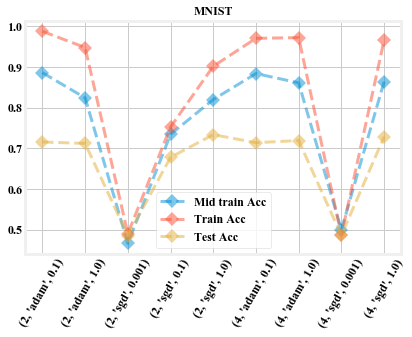

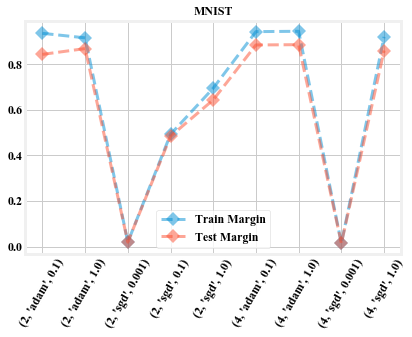

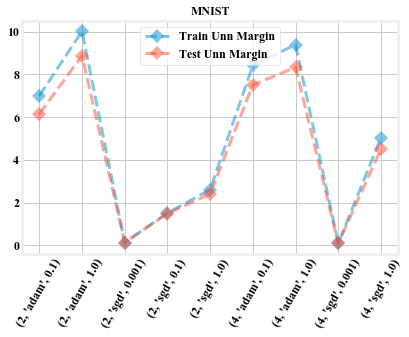

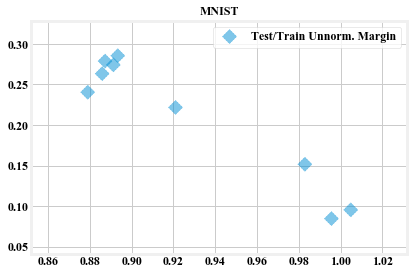

In [196]:
# plt.figure(figsize=[14, 30])
for j, NL in enumerate([2]):

    idxs = np.array([r_mu.index[i][0] >= NL for i in range(len(r_mu))])
#     plt.subplot(4, 2, j+1)
#     plt.figure(figsize=[4, 4])
    plt.plot(r_mu.mid_train_acc[idxs].values, marker='D', linestyle='--', label='Mid train Acc')
    plt.plot(r_mu.final_train_acc[idxs].values, marker='D', linestyle='--', label='Train Acc')
    plt.plot(r_mu.final_test_acc[idxs].values,  marker='D', linestyle='--', label='Test Acc')
    plt.legend()
#     plt.ylim([0.8, 1.])
    plt.xticks(np.arange(len(r_mu[idxs])), r_mu.index[idxs], rotation=60)
    plt.title('MNIST')
    plt.show()

#     plt.subplot(4, 2, j+3)
#     plt.figure(figsize=[4, 4])
    plt.plot(r_mu.final_train_margin[idxs].values, marker='D', linestyle='--', label='Train Margin')
    plt.plot(r_mu.final_test_margin[idxs].values,  marker='D', linestyle='--', label='Test Margin')
    plt.legend()
    plt.xticks(np.arange(len(r_mu[idxs])), r_mu.index[idxs], rotation=60)
    plt.title('MNIST')
    plt.show()


                                     
#     plt.subplot(4, 2, j+5)
    plt.plot(r_mu.final_train_margin_unn[idxs].values,  marker='D', linestyle='--', label='Train Unn Margin')
    plt.plot(r_mu.final_test_margin_unn[idxs].values,  marker='D', linestyle='--', label='Test Unn Margin')
    plt.xticks(np.arange(len(r_mu[idxs])), r_mu.index[idxs], rotation=60)
    plt.legend()
    plt.xticks(np.arange(len(r_mu[idxs])), r_mu.index[idxs], rotation=60)
    plt.title('MNIST')
    plt.show()
    
#     plt.subplot(4, 2, j+7)
    plt.scatter(r_mu.final_test_margin_unn[idxs].values/r_mu.final_train_margin_unn[idxs].values, 
             r_mu.corr0_final[idxs], marker='D', linestyle='--', label='Test/Train Unnorm. Margin')
#     plt.xticks(np.arange(len(r_mu[idxs])), r_mu.index[idxs], rotation=60)
    plt.legend()
    plt.title('MNIST')
    plt.show()

# Visualize first layer of these 12 networks or at least a few good/bad ones..

In [197]:
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

In [213]:
results[['lr', 'optimizer', 'num_layers', 'seed', 
         'mid_train_acc','final_train_acc', 'final_test_acc',
         'corr0_final']][(results['num_layers']==4) ].sort_values(by='corr0_final')

,lr,optimizer,num_layers,seed,mid_train_acc,final_train_acc,final_test_acc,corr0_final
7,0.001,sgd,4,0,0.50012,0.48644,0.4864,0.084535
4,0.100,adam,4,0,0.87572,0.97036,0.7194,0.273102
13,0.100,adam,4,1,0.89220,0.97064,0.7090,0.275012
10,1.000,adam,4,1,0.87168,0.97024,0.7170,0.278112
20,1.000,adam,4,0,0.85072,0.97440,0.7218,0.279358
5,1.000,sgd,4,0,0.86816,0.96208,0.7310,0.284105
8,1.000,sgd,4,1,0.85988,0.96916,0.7262,0.286575


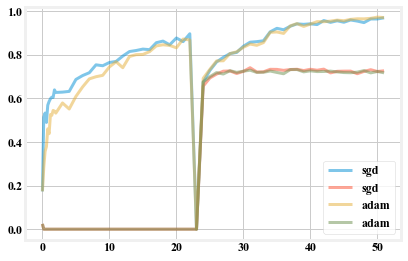

In [214]:
for i in [8, 10]:
    plt.plot(its, results['accs_train'][i], label=results.optimizer[i])
    plt.plot(its, results['accs_test'][i], label=results.optimizer[i])
#     plt.plot(its, results['mean_margin_train_unn'][i], label=results.optimizer[i])
#     plt.plot(its, results['mean_margin_test_unn'][i], label=results.optimizer[i])
plt.legend()
plt.show()

In [218]:
idx = 8
dset = 'cifar10'
# viz_weights.plot_weights(rw.weights[idx][22]['fc.0.weight'], dset=dset)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight'], dset=dset)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight']-rw.weights[idx][22]['fc.0.weight'], dset=dset)

In [217]:
idx = 10
# viz_weights.plot_weights(rw.weights[idx][22]['fc.0.weight'], dset=dset)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight'], dset=dset)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight']-rw.weights[idx][22]['fc.0.weight'], dset=dset)